# Homework 6
*This notebook includes both coding and written questions. Please hand in this notebook file with all the outputs as a pdf on gradescope for "HW6 pdf". Upload the three files of code (`compression.py`, `k_nearest_neighbor.py` and `features.py`) on gradescope for "HW6 code".*

This assignment covers:
- image compression using SVD
- kNN methods for image recognition.
- PCA and LDA to improve kNN

In [1]:
# Setup
from time import time
from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
from skimage import io

%matplotlib inline
plt.rcParams['figure.figsize'] = (15.0, 12.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
%load_ext autoreload
%autoreload 2

## Part 1 - Image Compression (15 points)

Image compression is used to reduce the cost of storage and transmission of images (or videos).
One lossy compression method is to apply Singular Value Decomposition (SVD) to an image, and only keep the top n singular values.

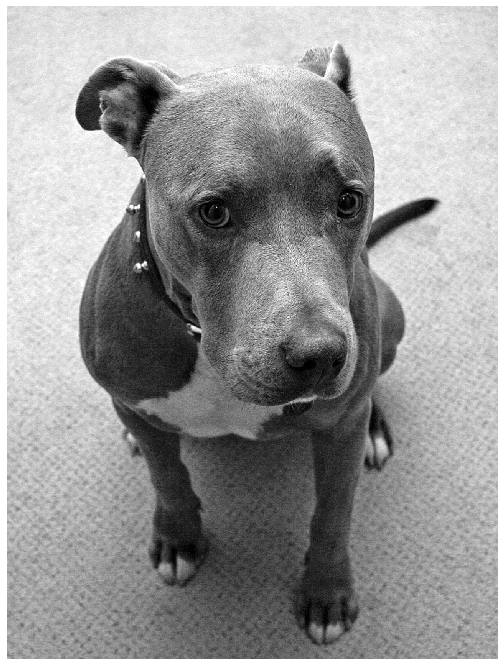

In [3]:
image = io.imread('pitbull.jpg', as_gray=True)
plt.imshow(image)
plt.axis('off')
plt.show()

Let's implement image compression using SVD.  
We first compute the SVD of the image, and as seen in class we keep the `n` largest singular values and singular vectors to reconstruct the image.

Implement function `compress_image` in `compression.py`.

In [17]:
from compression import compress_image

compressed_image, compressed_size = compress_image(image, 100)
compression_ratio = compressed_size / image.size
print('Original image shape:', image.shape)
print('Compressed size: %d' % compressed_size)
print('Compression ratio: %.3f' % compression_ratio)

assert compressed_size == 298500

Original image shape: (1704, 1280)
Compressed size: 298500
Compression ratio: 0.137


Data size (original): 2181120
Data size (compressed): 29850
Compression ratio: 0.013686


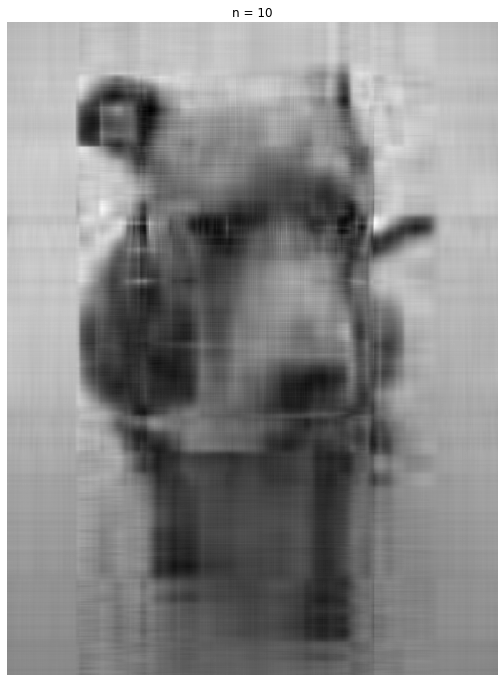

Data size (original): 2181120
Data size (compressed): 149250
Compression ratio: 0.068428


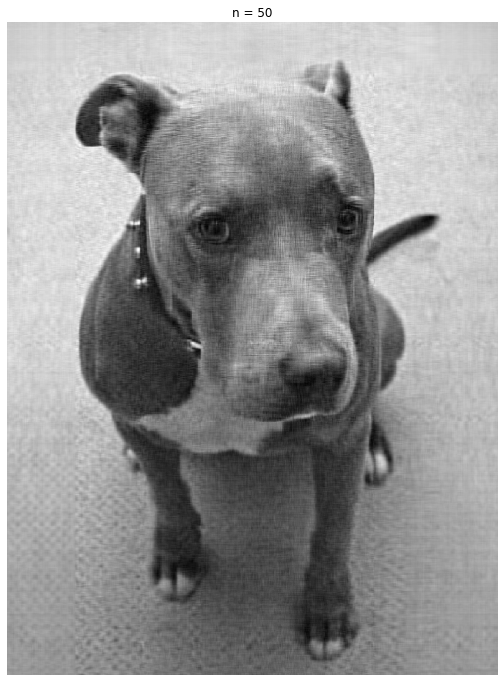

Data size (original): 2181120
Data size (compressed): 298500
Compression ratio: 0.136856


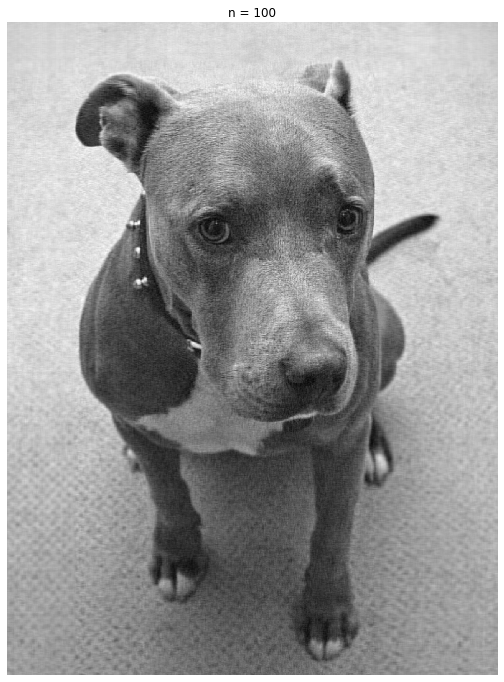

In [18]:
# Number of singular values to keep
n_values = [10, 50, 100]

for n in n_values:
    # Compress the image using `n` singular values
    compressed_image, compressed_size = compress_image(image, n)
    
    compression_ratio = compressed_size / image.size

    print("Data size (original): %d" % (image.size))
    print("Data size (compressed): %d" % compressed_size)
    print("Compression ratio: %f" % (compression_ratio))



    plt.imshow(compressed_image, cmap='gray')
    title = "n = %s" % n
    plt.title(title)
    plt.axis('off')
    plt.show()

## Face Dataset

We will use a dataset of faces of celebrities. Download the dataset using the following command:

    sh get_dataset.sh

The face dataset for CS131 assignment.
The directory containing the dataset has the following structure:

    faces/
        train/
            angelina jolie/
            anne hathaway/
            ...
        test/
            angelina jolie/
            anne hathaway/
            ...

Each class has 50 training images and 10 testing images.

In [24]:
from utils import load_dataset

X_train, y_train, classes_train = load_dataset('faces', train=True, as_grey=True)
X_test, y_test, classes_test = load_dataset('faces', train=False, as_grey=True)

assert classes_train == classes_test
classes = classes_train

print('Class names:', classes)
print('Training data shape:', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape:', X_test.shape)
print('Test labels shape: ', y_test.shape)

Class names: ['angelina jolie', 'anne hathaway', 'barack obama', 'brad pitt', 'cristiano ronaldo', 'emma watson', 'george clooney', 'hillary clinton', 'jennifer aniston', 'johnny depp', 'justin timberlake', 'leonardo dicaprio', 'natalie portman', 'nicole kidman', 'scarlett johansson', 'tom cruise']
Training data shape: (800, 64, 64)
Training labels shape:  (800,)
Test data shape: (160, 64, 64)
Test labels shape:  (160,)


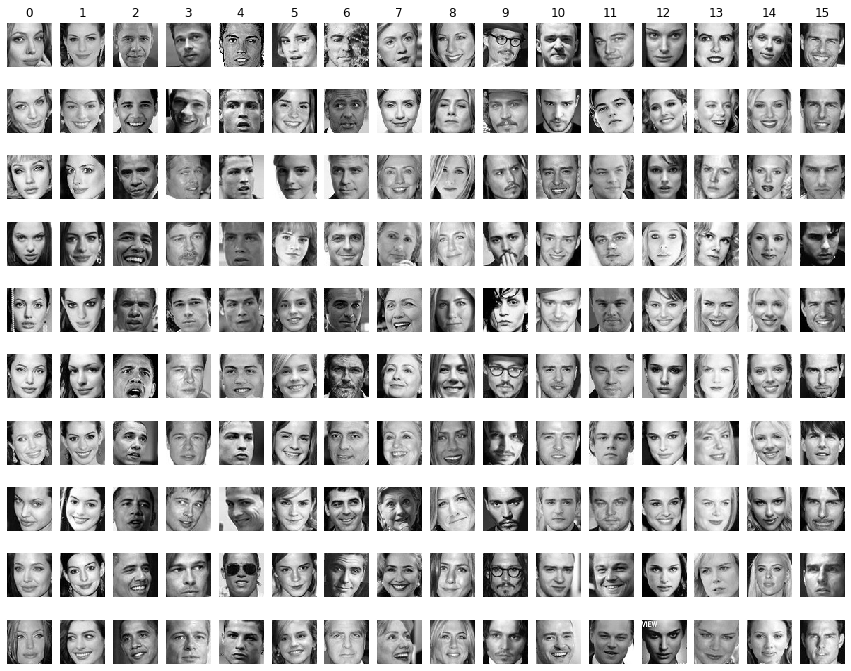

In [25]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
num_classes = len(classes)
samples_per_class = 10
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx])
        plt.axis('off')
        if i == 0:
            plt.title(y)
plt.show()

In [64]:
# Flatten the image data into rows
# we now have one 4096 dimensional featue vector for each example
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
print("Training data shape:", X_train.shape)
print("Test data shape:", X_test.shape)

Training data shape: (800, 4096)
Test data shape: (160, 4096)


---
## Part 2 - k-Nearest Neighbor (30 points)

We're now going to try to classify the test images using the k-nearest neighbors algorithm on the **raw features of the images** (i.e. the pixel values themselves). We will see later how we can use kNN on better features.

Here are the steps that we will follow:

1. We compute the L2 distances between every element of X_test and every element of X_train in `compute_distances`.
2. We split the dataset into 5 folds for cross-validation in `split_folds`.
3. For each fold, and for different values of `k`, we predict the labels and measure accuracy.
4. Using the best `k` found through cross-validation, we measure accuracy on the test set.

In [69]:
from k_nearest_neighbor import compute_distances

# Step 1: compute the distances between all features from X_train and from X_test
dists = compute_distances(X_test, X_train)
assert dists.shape == (160, 800)
print("dists shape:", dists.shape)

(160, 4096) (160,) (800, 4096) (800,)
dists shape: (160, 800)


In [92]:
from k_nearest_neighbor import predict_labels

# We use k = 1 (which corresponds to only taking the nearest neighbor to decide)
y_test_pred = predict_labels(dists, y_train, k=1)

# Compute and print the fraction of correctly predicted examples
num_test = y_test.shape[0]
print(y_test_pred.shape, y_test.shape)
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

(160,) (160,)
Got 38 / 160 correct => accuracy: 0.237500


### Cross-Validation

We don't know the best value for our parameter `k`.  
There is no theory on how to choose an optimal `k`, and the way to choose it is through cross-validation.

We **cannot** compute any metric on the test set to choose the best `k`, because we want our final test accuracy to reflect a real use case. This real use case would be a setting where we have new examples come and we classify them on the go. There is no way to check the accuracy beforehand on that set of test examples to determine `k`.

Cross-validation will make use split the data into different fold (5 here).  
For each fold, if we have a total of 5 folds we will have:
- 80% of the data as training data
- 20% of the data as validation data

We will compute the accuracy on the validation accuracy for each fold, and use the mean of these 5 accuracies to determine the best parameter `k`.

In [50]:
from k_nearest_neighbor import split_folds

# Step 2: split the data into 5 folds to perform cross-validation.
num_folds = 5

X_trains, y_trains, X_vals, y_vals = split_folds(X_train, y_train, num_folds)

assert X_trains.shape == (5, 640, 4096)
assert y_trains.shape == (5, 640)
assert X_vals.shape == (5, 160, 4096)
assert y_vals.shape == (5, 160)

(5, 640, 4096) (5, 640) (5, 160, 4096) (5, 160)
(5, 160)


In [94]:
# Step 3: Measure the mean accuracy for each value of `k`

# List of k to choose from
k_choices = list(range(5, 101, 5))

# Dictionnary mapping k values to accuracies
# For each k value, we will have `num_folds` accuracies to compute
# k_to_accuracies[1] will be for instance [0.22, 0.23, 0.19, 0.25, 0.20] for 5 folds
k_to_accuracies = {}

for k in k_choices:
    print("Running for k=%d" % k)
    accuracies = []
    for i in range(num_folds):
        # Make predictions
        fold_dists = compute_distances(X_vals[i], X_trains[i])
        y_pred = predict_labels(fold_dists, y_trains[i], k)

        # Compute and print the fraction of correctly predicted examples
        num_correct = np.sum(y_pred == y_vals[i])
        accuracy = float(num_correct) / len(y_vals[i])
        accuracies.append(accuracy)
        
    k_to_accuracies[k] = accuracies


Running for k=5
(160, 4096) (160,) (640, 4096) (640,)
(160, 4096) (160,) (640, 4096) (640,)
(160, 4096) (160,) (640, 4096) (640,)
(160, 4096) (160,) (640, 4096) (640,)
(160, 4096) (160,) (640, 4096) (640,)
Running for k=10
(160, 4096) (160,) (640, 4096) (640,)
(160, 4096) (160,) (640, 4096) (640,)
(160, 4096) (160,) (640, 4096) (640,)
(160, 4096) (160,) (640, 4096) (640,)
(160, 4096) (160,) (640, 4096) (640,)
Running for k=15
(160, 4096) (160,) (640, 4096) (640,)
(160, 4096) (160,) (640, 4096) (640,)
(160, 4096) (160,) (640, 4096) (640,)
(160, 4096) (160,) (640, 4096) (640,)
(160, 4096) (160,) (640, 4096) (640,)
Running for k=20
(160, 4096) (160,) (640, 4096) (640,)
(160, 4096) (160,) (640, 4096) (640,)
(160, 4096) (160,) (640, 4096) (640,)
(160, 4096) (160,) (640, 4096) (640,)
(160, 4096) (160,) (640, 4096) (640,)
Running for k=25
(160, 4096) (160,) (640, 4096) (640,)
(160, 4096) (160,) (640, 4096) (640,)
(160, 4096) (160,) (640, 4096) (640,)
(160, 4096) (160,) (640, 4096) (640,)
(160

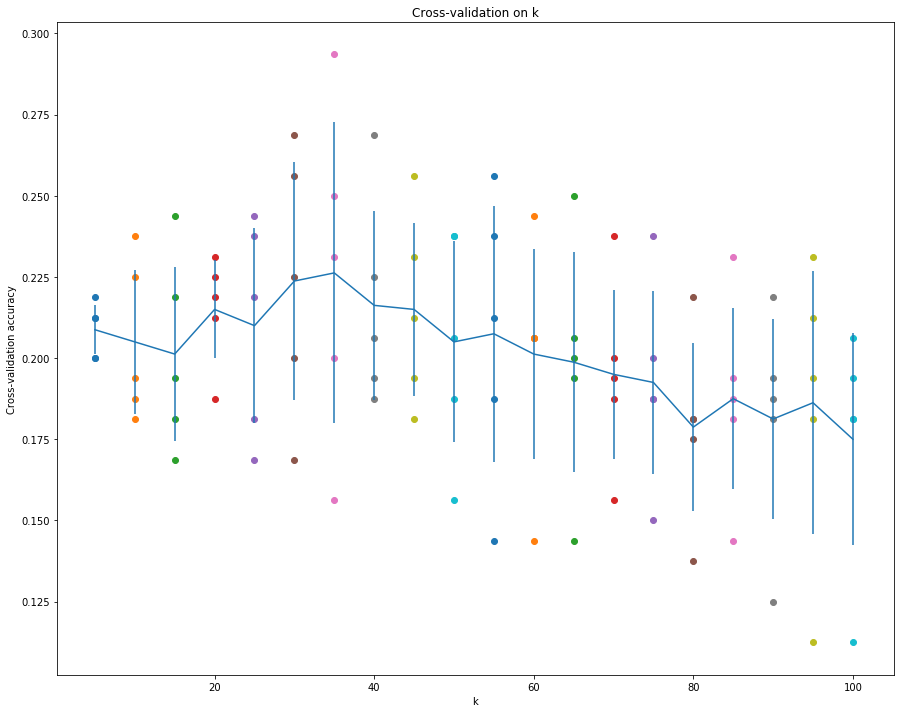

In [99]:
# plot the raw observations
for k in k_choices:
    accuracies = k_to_accuracies[k]
    plt.scatter([k] * len(accuracies), accuracies)

# plot the trend line with error bars that correspond to standard deviation
accuracies_mean = np.array([np.mean(v) for k,v in sorted(k_to_accuracies.items())])
accuracies_std = np.array([np.std(v) for k,v in sorted(k_to_accuracies.items())])
plt.errorbar(k_choices, accuracies_mean, yerr=accuracies_std)
plt.title('Cross-validation on k')
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy')
plt.show()

In [105]:
# Based on the cross-validation results above, choose the best value for k,   
# retrain the classifier using all the training data, and test it on the test
# data. You should be able to get above 26% accuracy on the test data.

best_k = 35
# YOUR CODE HERE
# Choose the best k based on the cross validation above
pass
# END YOUR CODE

y_test_pred = predict_labels(dists, y_train, k=best_k)

# Compute and display the accuracy
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('For k = %d, got %d / %d correct => accuracy: %f' % (best_k, num_correct, num_test, accuracy))

For k = 35, got 46 / 160 correct => accuracy: 0.287500


---
## Part 3: PCA (30 points)

Principal Component Analysis (PCA) is a simple yet popular and useful linear transformation technique that is used in numerous applications, such as stock market predictions, the analysis of gene expression data, and many more. In this tutorial, we will see that PCA is not just a "black box", and we are going to unravel its internals in 3 basic steps.

### Introduction
The sheer size of data in the modern age is not only a challenge for computer hardware but also a main bottleneck for the performance of many machine learning algorithms. The main goal of a PCA analysis is to identify patterns in data; PCA aims to detect the correlation between variables. If a strong correlation between variables exists, the attempt to reduce the dimensionality only makes sense. In a nutshell, this is what PCA is all about: Finding the directions of maximum variance in high-dimensional data and project it onto a smaller dimensional subspace while retaining most of the information.

### A Summary of the PCA Approach
- Standardize the data.
- Obtain the Eigenvectors and Eigenvalues from the covariance matrix or correlation matrix, or perform Singular Vector Decomposition.
- Sort eigenvalues in descending order and choose the $k$ eigenvectors that correspond to the $k$ largest eigenvalues where $k$ is the number of dimensions of the new feature subspace ($k \leq d$).
- Construct the projection matrix $\mathbf{W}$ from the selected $k$ eigenvectors.
- Transform the original dataset $\mathbf{X}$ via $\mathbf{W}$ to obtain a $k$-dimensional feature subspace Y.

In [107]:
from features import PCA

pca = PCA()

### 3.1 - Eigendecomposition
The eigenvectors and eigenvalues of a covariance (or correlation) matrix represent the "core" of a PCA: The eigenvectors (principal components) determine the directions of the new feature space, and the eigenvalues determine their magnitude. In other words, the eigenvalues explain the variance of the data along the new feature axes.

Implement **`_eigen_decomp`** in `pca.py`.

In [114]:
# Perform eigenvalue decomposition on the covariance matrix of training data.
e_vecs, e_vals = pca._eigen_decomp(X_train - X_train.mean(axis=0))

print(e_vals.shape)
print(e_vecs.shape)

(4096,)
(4096, 4096)


### 3.2 - Singular Value Decomposition
Doing an eigendecomposition of the covariance matrix is very expensive, especially when the number of features (`D = 4096` here) gets very high.

To obtain the same eigenvalues and eigenvectors in a more efficient way, we can use Singular Value Decomposition (SVD). If we perform SVD on matrix $X$, we obtain $U$, $S$ and $V$ such that:
$$
X = U S V^T
$$

- the columns of $U$ are the eigenvectors of $X X^T$
- the columns of $V^T$ are the eigenvectors of $X^T X$
- the values of $S$ are the square roots of the eigenvalues of $X^T X$ (or $X X^T$)


Therefore, we can find out the top `k` eigenvectors of the covariance matrix $X^T X$ using SVD.

Implement **`_svd`** in `pca.py`.

In [120]:
# Perform SVD on directly on the training data.
u, s = pca._svd(X_train - X_train.mean(axis=0))

print(s.shape)
print(u.shape)

(800,)
(4096, 4096)


In [122]:
# Test whether the square of singular values and eigenvalues are the same.
# We also observe that `e_vecs` and `u` are the same (only the sign of each column can differ).
N = X_train.shape[0]
assert np.allclose((s ** 2) / (N - 1), e_vals[:len(s)])

for i in range(len(s) - 1):
    assert np.allclose(e_vecs[:, i], u[:, i]) or np.allclose(e_vecs[:, i], -u[:, i])
    # (the last eigenvector for i = len(s) - 1 is very noisy because the eigenvalue is almost 0,
    #  so imprecisions in the computation build up)

### 3.3 - Dimensionality Reduction

The top $k$ principal components explain most of the variance of the underlying data.

By projecting our initial data (the images) onto the subspace spanned by the top k principal components,
we can reduce the dimension of our inputs while keeping most of the information.

In the example below, we can see that **using the first two components in PCA is not enough** to allow us to see pattern in the data. All the classes seem placed at random in the 2D plane.

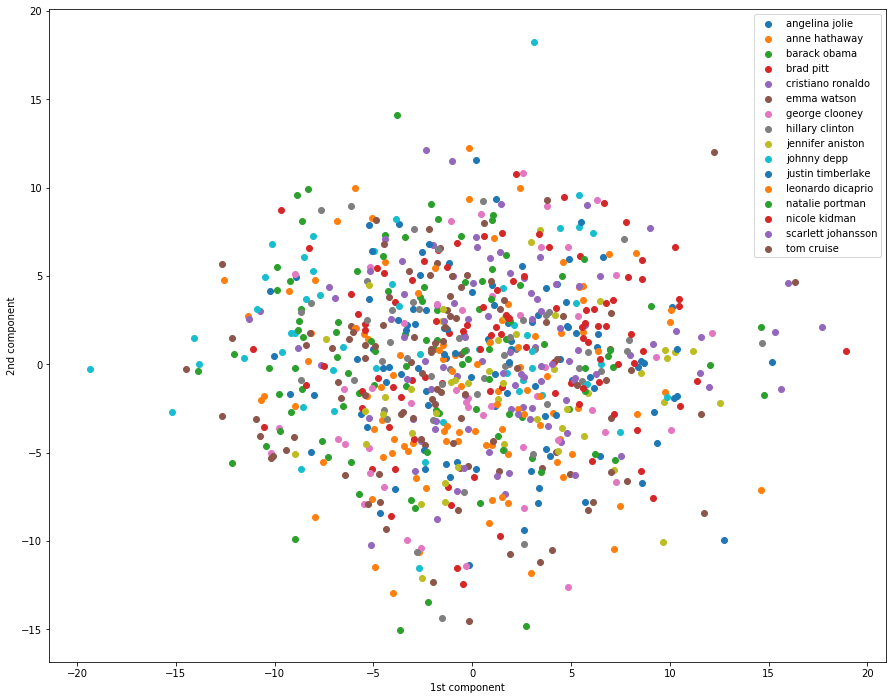

In [125]:
# Dimensionality reduction by projecting the data onto
# lower dimensional subspace spanned by k principal components

# To visualize, we will project in 2 dimensions
n_components = 2
pca.fit(X_train)
X_proj = pca.transform(X_train, n_components)

# Plot the top two principal components
for y in np.unique(y_train):
    plt.scatter(X_proj[y_train==y,0], X_proj[y_train==y,1], label=classes[y])
    
plt.xlabel('1st component')
plt.ylabel('2nd component')
plt.legend()
plt.show()

### 3.4 - Visualizing Eigenfaces

The columns of the PCA projection matrix `pca.W_pca` represent the eigenvectors of $X^T X$.

We can visualize the biggest singular values as well as the corresponding vectors to get a sense of what the PCA algorithm is extracting.

If we visualize the top 10 eigenfaces, we can see tht the algorithm focuses on the different shades of the faces. For instance, in face n°2 the light seems to come from the left.

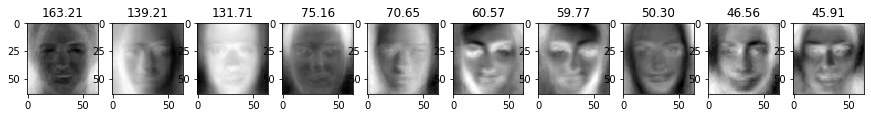

In [127]:
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(pca.W_pca[:, i].reshape(64, 64))
    plt.title("%.2f" % s[i])
plt.show()

(800, 4096)
['angelina jolie', 'anne hathaway', 'barack obama', 'brad pitt', 'cristiano ronaldo', 'emma watson', 'george clooney', 'hillary clinton', 'jennifer aniston', 'johnny depp', 'justin timberlake', 'leonardo dicaprio', 'natalie portman', 'nicole kidman', 'scarlett johansson', 'tom cruise']


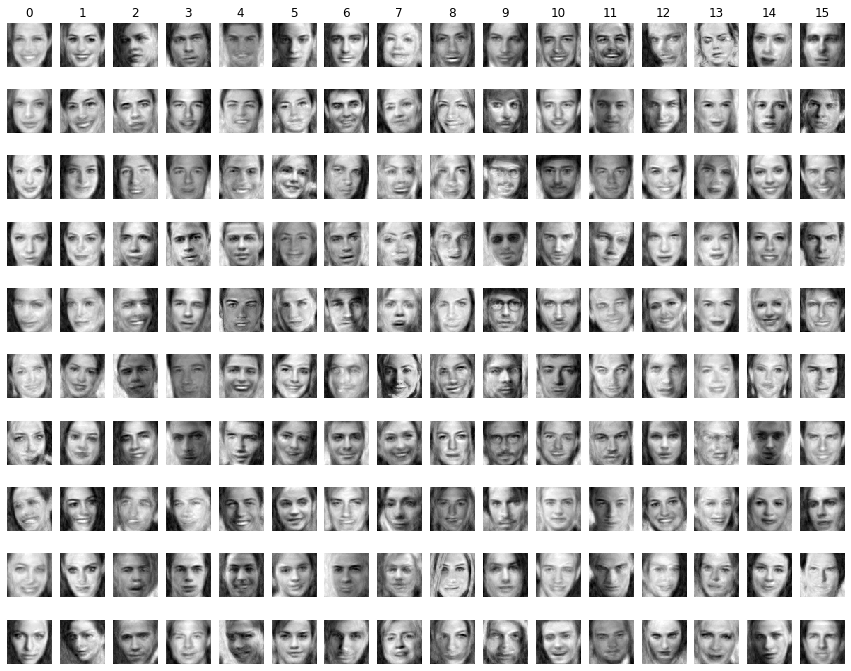

In [131]:
# Reconstruct data with principal components
n_components = 100  # Experiment with different number of components.
X_proj = pca.transform(X_train, n_components)
X_rec = pca.reconstruct(X_proj)

print(X_rec.shape)
print(classes)

# Visualize reconstructed faces
samples_per_class = 10
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow((X_rec[idx]).reshape((64, 64)))
        plt.axis('off')
        if i == 0:
            plt.title(y)
plt.show()

### Written Question 1 (5 points) 
*Question*: Consider a dataset of $N$ face images, each with shape $(h, w)$. Then, we need $O(Nhw)$ of memory to store the data. Suppose we perform dimensionality reduction on the dataset with $p$ principal components, and use the components as bases to represent images. Calculate how much memory we need to store the images and the matrix used to get back to the original space.

Said in another way, how much memory does storing the compressed images **and** the uncompresser cost.

*Answer:* 
$O(Nhd) + O(wd)$

### 3.5 - Reconstruction error and captured variance

We can plot the reconstruction error with respect to the dimension of the projected space.

The reconstruction gets better with more components.

We can see in the plot that the inflexion point is around dimension 200 or 300. This means that using this number of components is a good compromise between good reconstruction and low dimension.

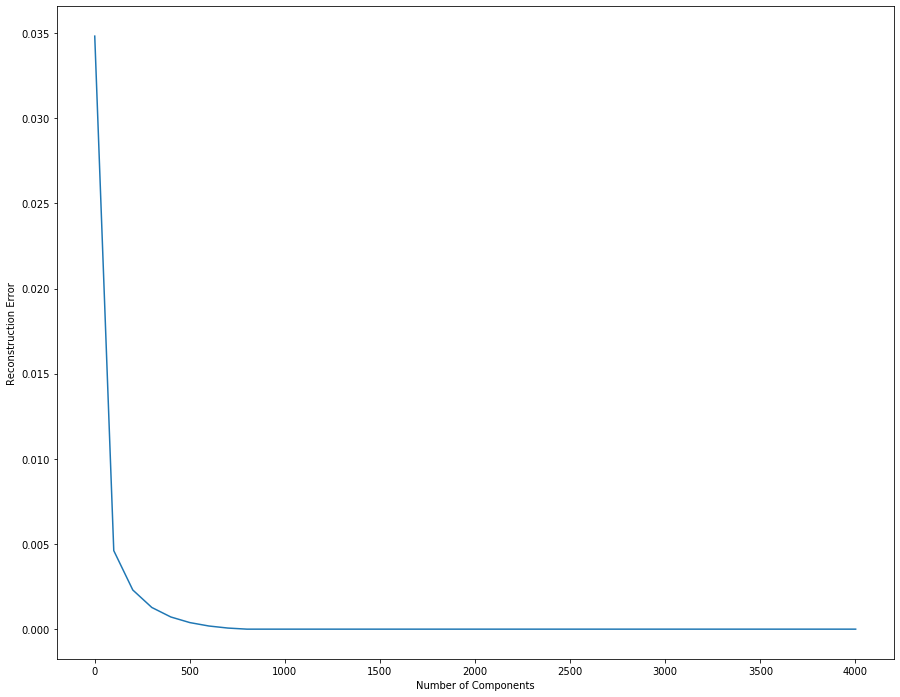

In [132]:
# Plot reconstruction errors for different k
N = X_train.shape[0]
d = X_train.shape[1]

ns = range(1, d, 100)
errors = []

for n in ns:
    X_proj = pca.transform(X_train, n)
    X_rec = pca.reconstruct(X_proj)

    # Compute reconstruction error
    error = np.mean((X_rec - X_train) ** 2)
    errors.append(error)

plt.plot(ns, errors)
plt.xlabel('Number of Components')
plt.ylabel('Reconstruction Error')
plt.show()

We can do the same process to see how much variance is captured by the projection.

Again, we see that the inflexion point is around 200 or 300 dimensions.

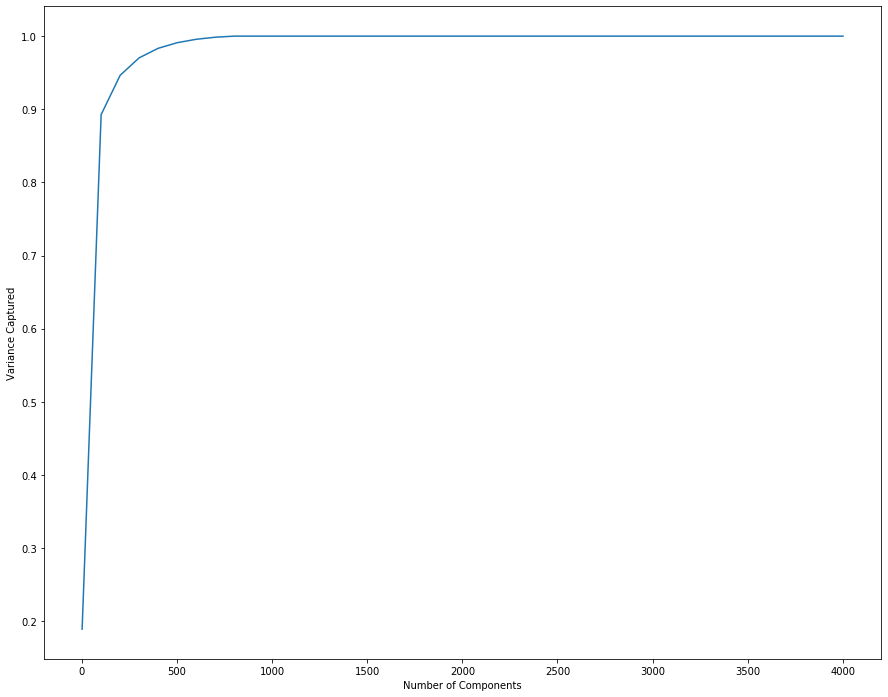

In [133]:
# Plot captured variance
ns = range(1, d, 100)
var_cap = []

for n in ns:
    var_cap.append(np.sum(s[:n] ** 2)/np.sum(s ** 2))
    
plt.plot(ns, var_cap)
plt.xlabel('Number of Components')
plt.ylabel('Variance Captured')
plt.show()

### 3.6 - kNN with PCA

Performing kNN on raw features (the pixels of the image) does not yield very good results.  
Computing the distance between images in the image space is not a very good metric for actual proximity of images.  
For instance, an image of person A with a dark background will be close to an image of B with a dark background, although these people are not the same.

Using a technique like PCA can help discover the real interesting features and perform kNN on them could give better accuracy.

However, we observe here that PCA doesn't really help to disentangle the features and obtain useful distance metrics between the different classes. We basically obtain the same performance as with raw features.

In [135]:
num_test = X_test.shape[0]

# We computed the best k and n for you
best_k = 35
best_n = 500


# PCA
pca = PCA()
pca.fit(X_train)
X_proj = pca.transform(X_train, best_n)
X_test_proj = pca.transform(X_test, best_n)

# kNN
dists = compute_distances(X_test_proj, X_proj)
y_test_pred = predict_labels(dists, y_train, k=best_k)

# Compute and display the accuracy
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

(160, 500) (160,) (800, 500) (800,)
Got 45 / 160 correct => accuracy: 0.281250


---
## Part 4 - Fisherface: Linear Discriminant Analysis (25 points)

LDA is a linear transformation method like PCA, but with a different goal.  
The main difference is that LDA takes information from the labels of the examples to maximize the separation of the different classes in the transformed space.

Therefore, LDA is not totally **unsupervised** since it requires labels. PCA is **fully unsupervised**.

In summary:
- PCA perserves maximum variance in the projected space.
- LDA preserves discrimination between classes in the project space. We want to maximize scatter between classes and minimize scatter intra class.

In [136]:
from features import LDA

lda = LDA()

### 4.1 - Dimensionality Reduction via PCA
To apply LDA, we need $D < N$. Since in our dataset, $N = 800$ and $D = 4096$, we first need to reduce the number of dimensions of the images using PCA.  
More information at: http://www.scholarpedia.org/article/Fisherfaces

In [137]:
N = X_train.shape[0]
c = num_classes

pca = PCA()
pca.fit(X_train)
X_train_pca = pca.transform(X_train, N-c)
X_test_pca = pca.transform(X_test, N-c)

### 4.2 - Scatter matrices

We first need to compute the within-class scatter matrix:
$$
S_W = \sum_{i=1}^c S_i
$$
where $S_i = \sum_{x_k \in Y_i} (x_k - \mu_i)(x_k - \mu_i)^T$ is the scatter of class $i$.

We then need to compute the between-class scatter matrix:
$$
S_B = \sum_{i=1}^c N_i (\mu_i - \mu)(\mu_i - \mu)^T
$$
where $N_i$ is the number of examples in class $i$.

In [177]:
# Compute within-class scatter matrix
S_W = lda._within_class_scatter(X_train_pca, y_train)
print(S_W.shape)

(784, 784)


In [178]:
# Compute between-class scatter matrix
S_B = lda._between_class_scatter(X_train_pca, y_train)
print(S_B.shape)

(784, 784)


### 4.3 - Solving generalized Eigenvalue problem

Implement methods `fit` and `transform` of the `LDA` class.

In [179]:
lda.fit(X_train_pca, y_train)

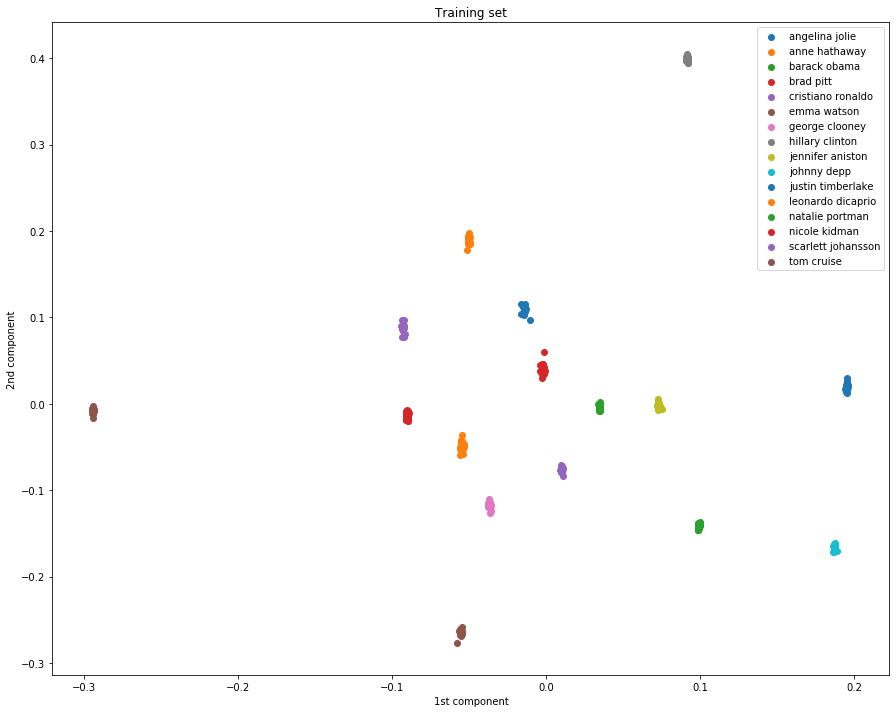

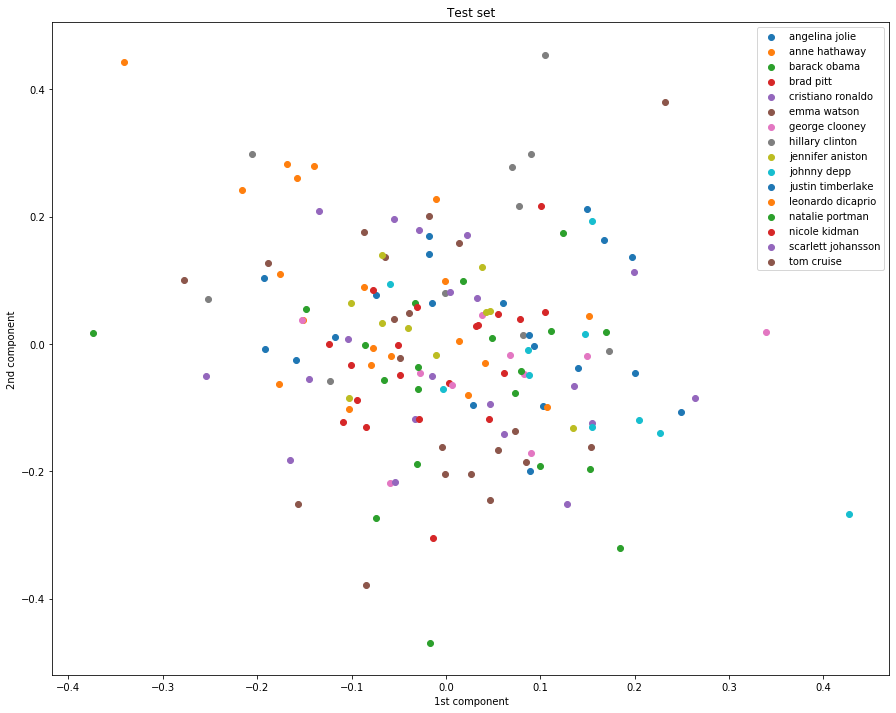

In [180]:
# Dimensionality reduction by projecting the data onto
# lower dimensional subspace spanned by k principal components
n_components = 2
X_proj = lda.transform(X_train_pca, n_components)
X_test_proj = lda.transform(X_test_pca, n_components)

# Plot the top two principal components on the training set
for y in np.unique(y_train):
    plt.scatter(X_proj[y_train==y, 0], X_proj[y_train==y, 1], label=classes[y])
    
plt.xlabel('1st component')
plt.ylabel('2nd component')
plt.legend()
plt.title("Training set")
plt.show()

# Plot the top two principal components on the test set
for y in np.unique(y_test):
    plt.scatter(X_test_proj[y_test==y, 0], X_test_proj[y_test==y,1], label=classes[y])
    
plt.xlabel('1st component')
plt.ylabel('2nd component')
plt.legend()
plt.title("Test set")
plt.show()

### 4.4 - kNN with LDA

Thanks to having the information from the labels, LDA gives a discriminant space where the classes are far apart from each other.  
This should help kNN a lot, as the job should just be to find the obvious 10 clusters.

However, as we've seen in the previous plot (section 4.3), the training data gets clustered pretty well, but the test data isn't as nicely clustered as the training data (overfitting?).


Perform cross validation following the code below (you can change the values of `k_choices` and `n_choices` to search). Using the best result from cross validation, obtain the test accuracy.

In [181]:
num_folds = 5
from tqdm import tqdm

X_trains, y_trains, X_vals, y_vals = split_folds(X_train, y_train, num_folds)

k_choices = [1, 5, 10, 20, 25, 30, 35]
n_choices = [5, 10, 20, 50, 100, 200, 500]
pass


# n_k_to_accuracies[(n, k)] should be a list of length num_folds giving the different
# accuracy values that we found when using that value of n and k.
n_k_to_accuracies = defaultdict(list)

for i in tqdm(range(num_folds)):
    # Fit PCA
    pca = PCA()
    pca.fit(X_trains[i])
    
    N = len(X_trains[i])
    X_train_pca = pca.transform(X_trains[i], N-c)
    X_val_pca = pca.transform(X_vals[i], N-c)
    
    # Fit LDA
    lda = LDA()
    lda.fit(X_train_pca, y_trains[i])
    
    for n in n_choices:
        X_train_proj = lda.transform(X_train_pca, n)
        X_val_proj = lda.transform(X_val_pca, n)

        dists = compute_distances(X_val_proj, X_train_proj)
            
        for k in k_choices:
            y_pred = predict_labels(dists, y_trains[i], k=k)

            # Compute and print the fraction of correctly predicted examples
            num_correct = np.sum(y_pred == y_vals[i])
            accuracy = float(num_correct) / len(y_vals[i])
            n_k_to_accuracies[(n, k)].append(accuracy)


for n in n_choices:
    print()
    for k in k_choices:
        accuracies = n_k_to_accuracies[(n, k)]
        print("For n=%d, k=%d: average accuracy is %f" % (n, k, np.mean(accuracies)))

100%|██████████| 5/5 [01:09<00:00, 13.92s/it]


For n=5, k=1: average accuracy is 0.188750
For n=5, k=5: average accuracy is 0.191250
For n=5, k=10: average accuracy is 0.191250
For n=5, k=20: average accuracy is 0.191250
For n=5, k=25: average accuracy is 0.191250
For n=5, k=30: average accuracy is 0.190000
For n=5, k=35: average accuracy is 0.190000

For n=10, k=1: average accuracy is 0.281250
For n=10, k=5: average accuracy is 0.290000
For n=10, k=10: average accuracy is 0.290000
For n=10, k=20: average accuracy is 0.295000
For n=10, k=25: average accuracy is 0.292500
For n=10, k=30: average accuracy is 0.291250
For n=10, k=35: average accuracy is 0.291250

For n=20, k=1: average accuracy is 0.377500
For n=20, k=5: average accuracy is 0.392500
For n=20, k=10: average accuracy is 0.391250
For n=20, k=20: average accuracy is 0.388750
For n=20, k=25: average accuracy is 0.400000
For n=20, k=30: average accuracy is 0.395000
For n=20, k=35: average accuracy is 0.390000

For n=50, k=1: average accuracy is 0.365000
For n=50, k=5: avera

In [175]:
# Based on the cross-validation results above, choose the best value for k,   
# retrain the classifier using all the training data, and test it on the test
# data. You should be able to get above 40% accuracy on the test data.

best_k = 35
best_n = 500
# YOUR CODE HERE
# Choose the best k based on the cross validation above
best_n, best_k = max(n_k_to_accuracies, key=n_k_to_accuracies.get)
print('best n {} best k {}'.format(best_n, best_k))

# END YOUR CODE

N = len(X_train)

# Fit PCA
pca = PCA()
pca.fit(X_train)
X_train_pca = pca.transform(X_train, N-c)
X_test_pca = pca.transform(X_test, N-c)

# Fit LDA
lda = LDA()
lda.fit(X_train_pca, y_train)

# Project using LDA
X_train_proj = lda.transform(X_train_pca, best_n)
X_test_proj = lda.transform(X_test_pca, best_n)

dists = compute_distances(X_test_proj, X_train_proj)
y_test_pred = predict_labels(dists, y_train, k=best_k)

# Compute and display the accuracy
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print("For k=%d and n=%d" % (best_k, best_n))
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

best n 20 best k 30
For k=30 and n=20
Got 69 / 160 correct => accuracy: 0.431250
